## 1. This... is... Jeopardy!
<p><img src="https://assets.datacamp.com/production/project_796/img/jeopardy_logo.png" alt=""></p>
<p>"This... is... <em>Jeopardy!</em>" These words will ring a bell for anyone who has watched the American game show, <em>Jeopardy!</em> . This iconic TV show could be described as quizbowl with gambling. In each 30-minute episode, three contestants compete in answering questions with specific monetary value, accumulating and wagering their earnings throughout each round. It's no petty cash, either; a recent <em>Jeopardy!</em> champion, James Holzhauer, walked away with $2.46 million after winning in 33 consecutive episodes. </p>
<p>However, for an aspiring <em>Jeopardy!</em> champion, the amount of knowledge required to excel at the game might seem discouraging at first glance. How can it be possible to know everything about everything? Some <em>Jeopardy!</em> enthusiasts have turned to data analysis for the answers&mdash;and we'll do just that. In this project, we'll use basic text mining techniques on <em>Jeopardy!</em> data to spot trends in the types of questions asked. Let's start by loading in the dataset and the packages we'll need. </p>

In [233]:
library(readr)
library(dplyr)
library(tm)
library(wordcloud)

jeopardy <- read_csv("datasets/jeopardy.csv")

Parsed with column specification:
cols(
  show_number = col_double(),
  air_date = col_character(),
  round = col_character(),
  category = col_character(),
  value = col_character(),
  question = col_character(),
  answer = col_character()
)


## 2. A glimpse ahead
<p><img src="https://assets.datacamp.com/production/project_796/img/Jeopardy_game_board.png" alt=""></p>
<p>Here are the basic rules of the game. Three contestants compete against each other in three rounds: <em><strong>Jeopardy</strong></em>, <em><strong>Double Jeopardy</strong></em>, and <em><strong>Final Jeopardy</strong></em>. In <em>Jeopardy</em> and <em>Double Jeopardy</em> , each round has six categories, with five answers per category. After an answer is read by the show's host, Alex Trebeck, each contestant competes to be the first to come up with the correct question to the answer. </p>
<p>Each answer has a monetary value based on its difficulty. The monetary values in the <em>Double Jeopardy</em> round are double the values of the answers in <em>Jeopardy</em> round. In <em>Final Jeopardy</em>, the contestants bet any amount from their accumulated earnings on one difficult answer. </p>
<p>For a complete breakdown of the rules, check out the <a href="https://en.wikipedia.org/wiki/Jeopardy!#Gameplay"><em>Jeopardy!</em> Wikipedia page</a>. Knowing the rules of the game will make the <code>jeopardy</code> dataset easier to understand!</p>

In [235]:
glimpse(jeopardy)
jeopardy[1:6,]

Observations: 116,837
Variables: 7
$ show_number <dbl> 4031, 4031, 4031, 4031, 4031, 4031, 4031, 4031, 4031, 4...
$ air_date    <chr> "2/25/2002", "2/25/2002", "2/25/2002", "2/25/2002", "2/...
$ round       <chr> "Jeopardy!", "Jeopardy!", "Jeopardy!", "Jeopardy!", "Je...
$ category    <chr> "AMERICAN HISTORY", "FIREFIGHTING", "GEOGRAPH\"E\"", "G...
$ value       <chr> "$200", "$200", "$200", "$200", "$200", "$200", "$400",...
$ question    <chr> "In 1805 this territory was created from the Indiana on...
$ answer      <chr> "Michigan", "the Hall of Flame", "Etna", "Gary Burghoff...


show_number,air_date,round,category,value,question,answer
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
4031,2/25/2002,Jeopardy!,AMERICAN HISTORY,$200,"In 1805 this territory was created from the Indiana one, with all or parts of the lower & upper peninsulas",Michigan
4031,2/25/2002,Jeopardy!,FIREFIGHTING,$200,"The firefighting museum in Phoenix, Arizona isn't called the Hall of Fame, but the hall of this",the Hall of Flame
4031,2/25/2002,Jeopardy!,"GEOGRAPH""E""",$200,Sicilians call this active volcano Mongibello,Etna
4031,2/25/2002,Jeopardy!,GIVE THE ROLE TO GARY,$200,"TV, 1972-1979: Walter ""Radar"" O'Reilly",Gary Burghoff
4031,2/25/2002,Jeopardy!,WED TO THE IDEA,$200,"The sacrament of marriage, it's ""holy""",matrimony
4031,2/25/2002,Jeopardy!,CRIMINAL CONVERSATION,$200,"Ice can refer to diamonds; chill can mean to do this, maybe with a lawnmower (a machine gun)",to kill


## 3. Corpus of categories
<p>Whew. Where do we even start? <em>Jeopardy!</em> questions and answers include all kinds of words&mdash;places, people, even obscure vocabulary. Did you know that "philately" means "love of stamp collecting?" Check out the data from show number 6108. </p>
<p>It might be better to start with a small-scale text analysis. Let's look at the <strong>categories</strong>. In addition to having clever and sometimes downright funny names, they'll tell us a little more about the content of the questions without having to analyze the question text. </p>
<p>We need to take the categories data and convert it to an easily-workable body of text&mdash;in other words, a corpus.</p>

In [237]:
categories <- jeopardy %>%
    filter(round == "Jeopardy!") %>%
    select(category)

categories_source <- VectorSource(categories)

categories_corp  <- VCorpus(categories_source)

    

## 4. Cleaning the categories
<p><em>Jeopardy!</em> categories are notorious for being witty and unique. An example of a category title is "Element, Spel-ement" (from the episode aired on March 28, 2011). Every question in this category gave the contestant a list of chemical element names, and the contestant had to spell the word created by the symbols of those elements (example: boron, aluminum, potassium = "balk"). </p>
<p>Some categories have more straightforward titles, such as the "Indonesia" category (from the episode on March 25, 2011), which had questions all about Indonesia.</p>
<p>You can imagine that text mining from these wordy and specific categories might be difficult&mdash;and this would probably be correct. Some cleaning is in order! Bust out the vacuums (or in this case, some <code>tm</code> package verbs).</p>

In [239]:
clean_corp <- tm_map(categories_corp, content_transformer(tolower))
clean_corp <- tm_map(clean_corp, removePunctuation)
clean_corp <- tm_map(clean_corp, stripWhitespace)
clean_corp <- tm_map(clean_corp, removeWords, stopwords("en"))

categories_tdm <- TermDocumentMatrix(clean_corp)

## 5. Favorite topics
<p>A basic, yet fairly effective analysis here would be a word-frequency analysis. If certain words popped on in category titles more often than others, we could reasonably assume that there are recurring themes in <em>Jeopardy!</em> categories. </p>
<p>First, we will need to turn the TDM into an M (a matrix). Then, we will rank the most frequent words.</p>

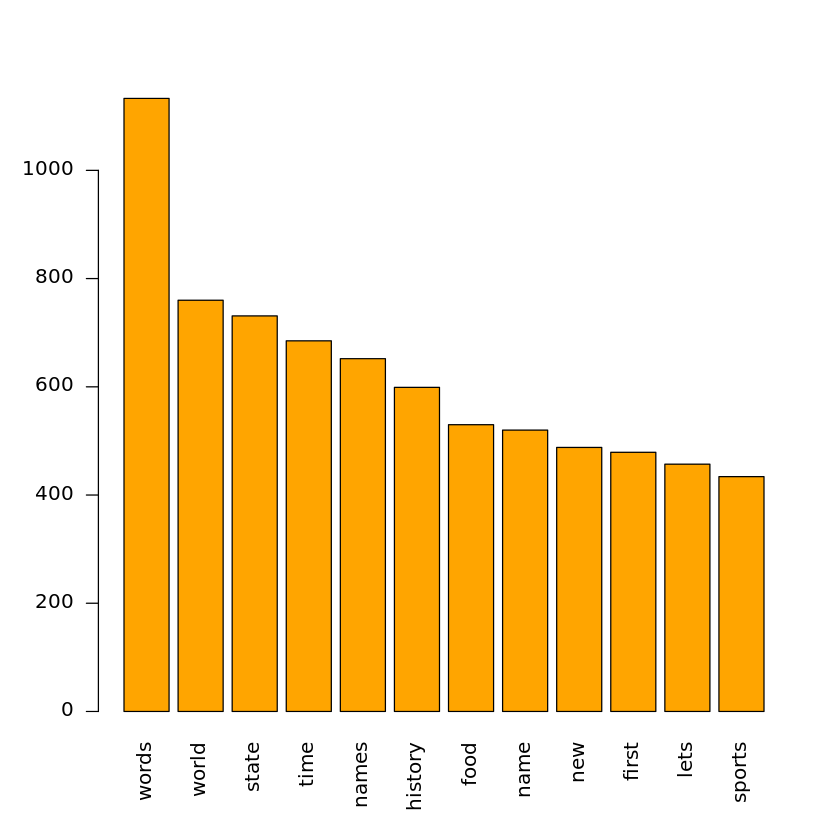

In [241]:
categories_m  <- as.matrix(categories_tdm)
term_frequency  <- sort(rowSums(categories_m), decreasing = TRUE)
barplot(term_frequency[1:12], col = "orange", las = 2)

## 6. Removing unwanted words
<p>That is a nice barplot...but we're in this for the money and <em>Jeopardy!</em> fame. Let's improve the bar plot by removing some unhelpful words: "time," "new," "first," and "lets."</p>

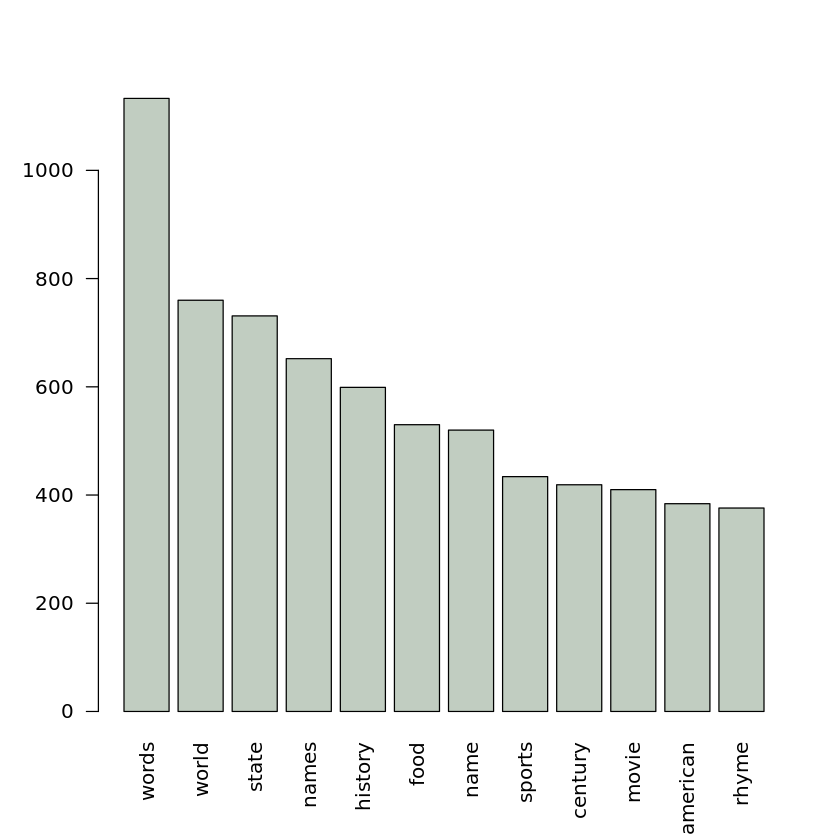

In [243]:
cleaner_corp <- tm_map(clean_corp, removeWords,
                      c(stopwords("en"), "time", "new", "first", "lets"))

cleaner_tdm <- TermDocumentMatrix(cleaner_corp)

categories_m  <- as.matrix(cleaner_tdm)
term_frequency  <- sort(rowSums(categories_m), decreasing = TRUE)
barplot(term_frequency[1:12], col = "honeydew3", las = 2)

## 7. Creating better tools, part 1
<p>A few of our top ranking category words are: "words," "world," "state," "name," and "history." </p>
<p>"Words" most likely refers to the wordplay or vocabulary categories, which appear often on the show. The other four words suggest that a <em>Jeopardy!</em> champion will need to know a lot about history, geography, and significant historical figures. However, when we go further down the plot, there's an interesting term&mdash;the 11th most common term is "American." Considering this is an American game show, it would make sense that the game requires the contestants to be <strong>most</strong> familiar with American history. We should look into this!</p>
<p>But first, let's save some time by condensing many lines of code into one. We'll write simple, one-line functions for the cleaning and term-frequency extraction processes.</p>

In [253]:
speed_clean <- function(corpus){
    clean_corp <- tm_map(corpus, content_transformer(tolower))
    clean_corp <- tm_map(corpus, removePunctuation)
    clean_corp <- tm_map(clean_corp, stripWhitespace)
    clean_corp <- tm_map(clean_corp, removeWords, stopwords("en"))
    return(clean_corp)
}

## 8. Creating better tools, part 2
<p>We can incorporate the <code>speed_clean()</code> function we just made into a new function that will extract frequent terms from an already-cleaned matrix. Then, we'll move on to <strong>Final Jeopardy</strong>, the last and toughest round (also, the one with the iconic <a href="https://www.youtube.com/watch?v=73tGe3JE5IU"><em>Jeopardy!</em> song</a>).</p>

In [247]:
freq_terms <- function(x){
    source <- VectorSource(x)
    corpus <- VCorpus(source)
    clean_corpus <- speed_clean(corpus)
    tdm <- TermDocumentMatrix(clean_corpus)
    matrix <- as.matrix(tdm)
    term_frequency <- sort(rowSums(matrix), decreasing = TRUE)
    return(term_frequency)
}

## 9. Think!
<p><strong>Final Jeopardy</strong> is arguably the most important round in the entire game&mdash;contestants bet any amount from their accumulated earnings on one answer. This answer is supposedly more difficult than all the questions in the previous rounds. The contestants make their bets before the answer is read and are given 30 seconds to write down their questions. You can probably imagine how much of a game-changer this round is (check out <a href="https://www.youtube.com/watch?v=SN2hQZWwOCU">this</a> for proof). </p>
<p>Since we've already looked at the categories, let's look at some of the correct answers to <strong>Final Jeopardy</strong> questions.</p>

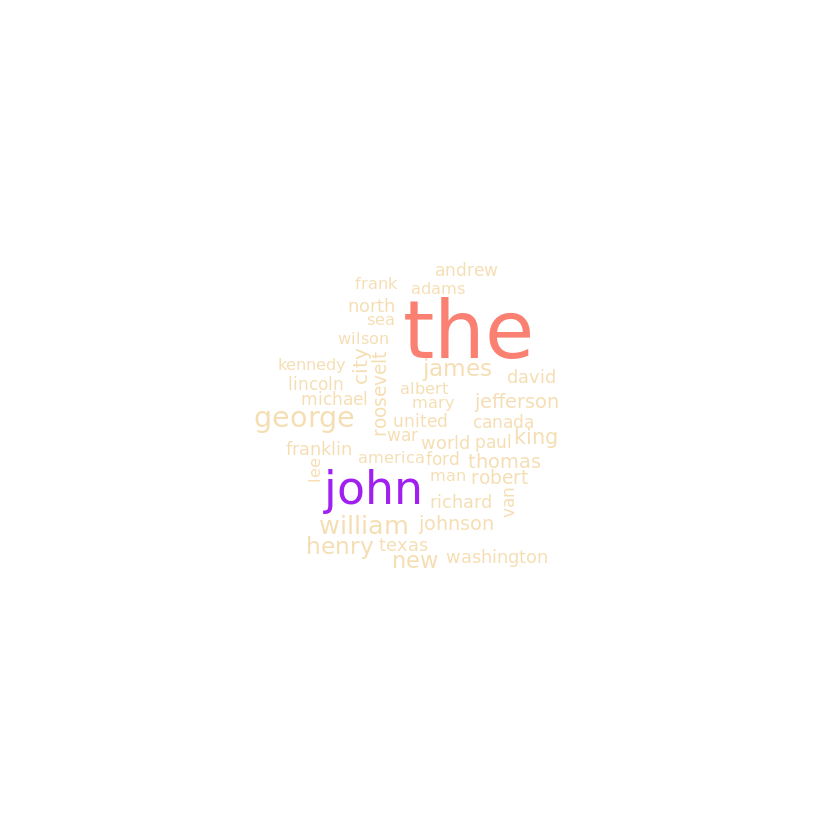

In [249]:
answers <- jeopardy %>% 
    filter(round == "Final Jeopardy!") %>% 
    select(answer)

ans_frequency <- freq_terms(answers)

ans_names <- names(ans_frequency)

wordcloud(ans_names, ans_frequency, max.words=40,
         colors = c("wheat", "purple", "salmon"))

## 10. A few insights
<p>John, William, James, and Henry... who might these people be? We don't know exactly, but the wordcloud seems to support and expand upon a hunch we had a little while ago - many <em>Jeopardy!</em> questions are drawn from American or European history. While it is certainly possible to get a category like "Indonesia," contestants are much more likely to be tested on the history, literature, or pop culture from the west. This might not be surprising, but there are plenty of other insights to be drawn from the dataset using the text mining techniques we have explored in this project.</p>
<p>As an aspiring <em>Jeopardy!</em> champion, which textbook might best help you study?</p>
<ul>
<li><p>a. "Geography of Indonesia"  </p></li>
<li><p>b. "Chemistry 101"  </p></li>
<li><p>c. "U.S. History"  </p></li>
<li><p>d. "Introduction to Text Mining in R"  </p></li>
</ul>

In [251]:
print("c")

[1] "c"
